In [98]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

SEED = 42

In [99]:
''' Performs k-fold cross validation. '''
def cross_validate(x, y, k, model):
    mean_err = 0.
    for i in range(k):
        # Split the training data into training and testing sets for cross-validation.
        x_train, x_cv, y_train, y_cv = train_test_split(x, y, test_size=float(1)/k, random_state=i*SEED)

        model.fit(x_train, y_train)

        # Calculate training error.
        preds = model.predict(x_cv)
        fold_err = model.score(x_cv, y_cv)
        mean_err += fold_err
    mean_err /= k
    print mean_err

In [100]:
''' Fills all missing values in the data with the mean of the respective feature. '''
def fillEmptys(data_frame):
    count = 0
    for feature in data_frame:
        for x in range(len(data_frame[feature])):
            if pd.isnull(data_frame[feature][x]):
                data_frame[feature][x] = data_frame[feature].mean()
                count += 1

In [136]:
''' Creates scatter plots for each feature. '''
def plot_features(data):
    for feature in data:
        if feature != 'id':
            plt.scatter(data['id'], data[feature])
            plt.title(feature)
            plt.show()

In [137]:
''' Finds the optimal hyper parameters for and XGB model. '''
''' WARNING: EXTREMELY LONG RUN-TIME '''
def optimize_xgb(train):
    tune_params = [{'max_depth': [k for k in range(40)]}, 
               {'learning_rate': [k for k in np.linspace(0.01, 0.05, 5)]},
               {'n_estimators': [k for k in range(300)]},
               {'gamma': [k for k in np.linspace(0.0, 0.1, 10)]}]
    gs = GridSearchCV(xgb.XGBClassifier(), tune_params, cv=5)
    gs.fit(train.drop(['id', 'Y'], axis=1), train['Y'])
    print gs.best_params_
    print gs.best_score_
    return gs.best_estimator_

In [138]:
''' Stacks the predictions from the given model onto the given training and testing data as 'new_feature'. '''
def stack_model(model, train, test, new_feature):
    model.fit(train.drop(['id', 'Y'], axis=1), train['Y'])
    train[new_feature] = pd.DataFrame(model.predict_proba(train.drop(['id', 'Y'], axis=1))[:,1])
    test[new_feature] = pd.DataFrame(model.predict_proba(test.drop(['id'], axis=1))[:,1])
    return train, test

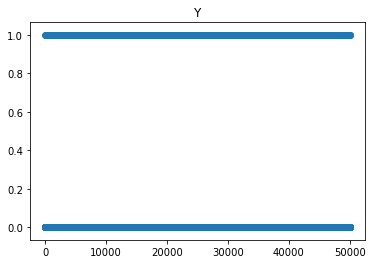

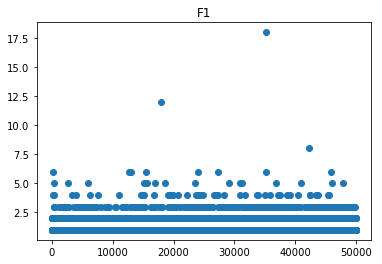

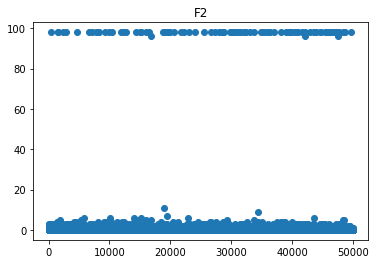

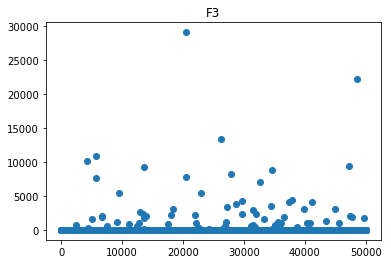

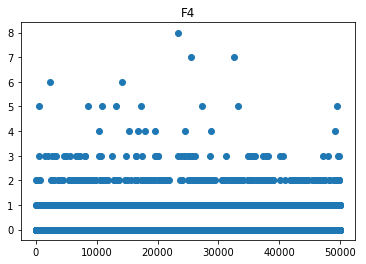

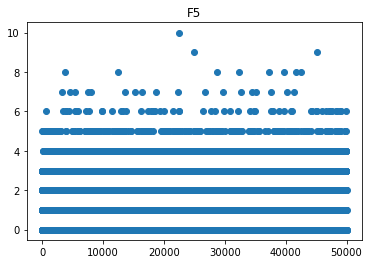

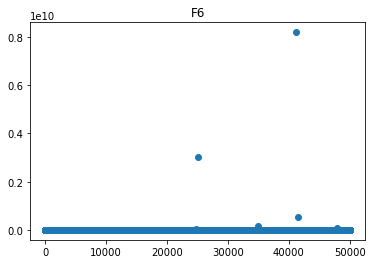

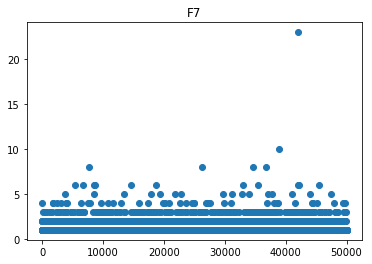

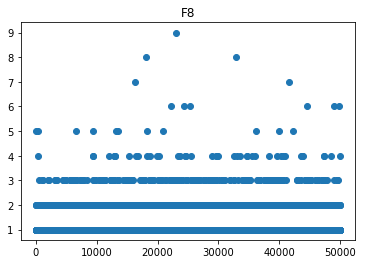

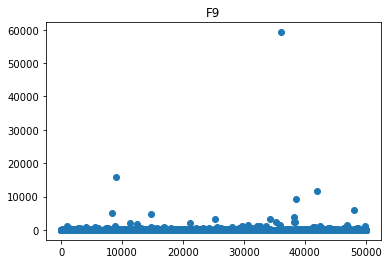

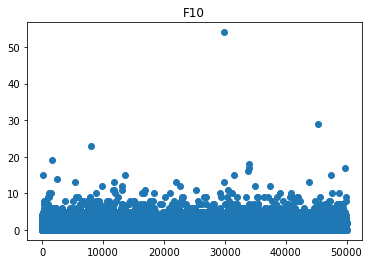

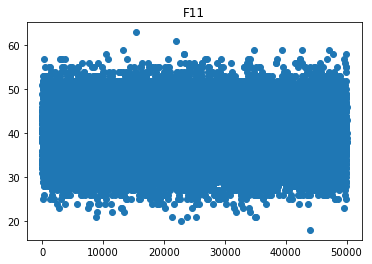

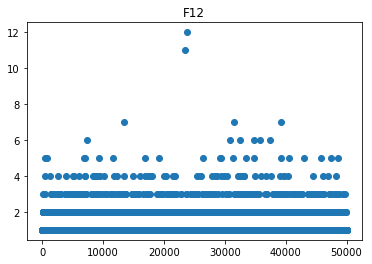

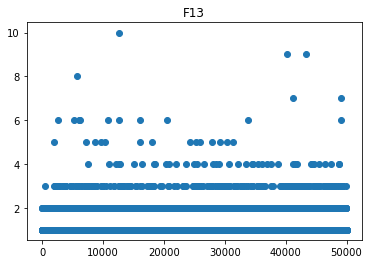

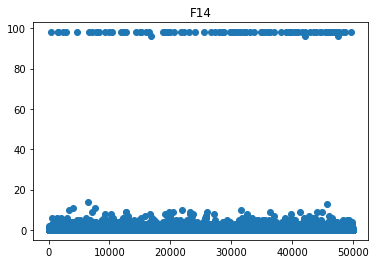

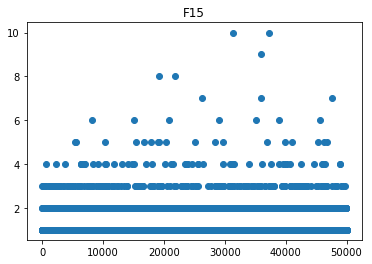

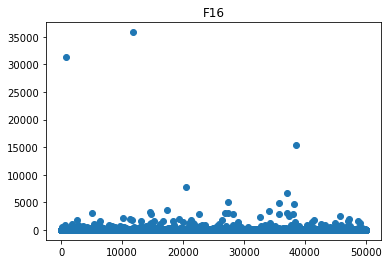

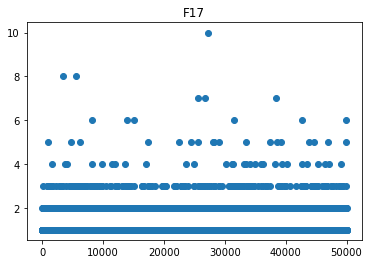

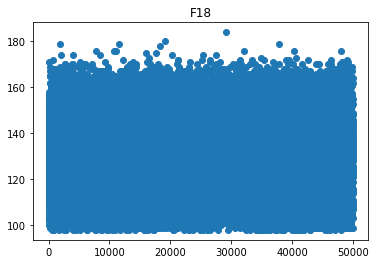

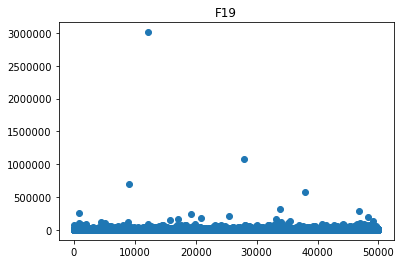

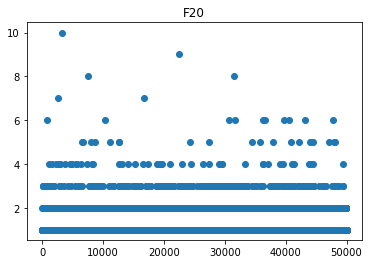

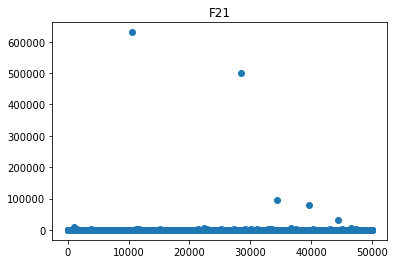

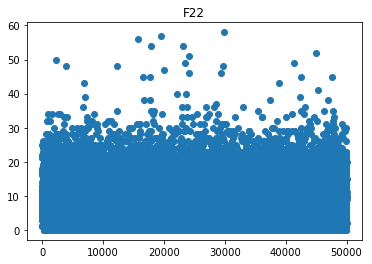

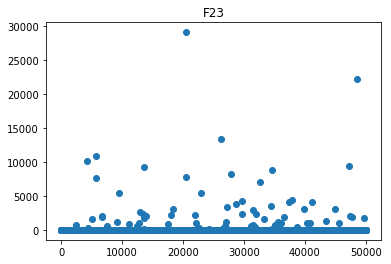

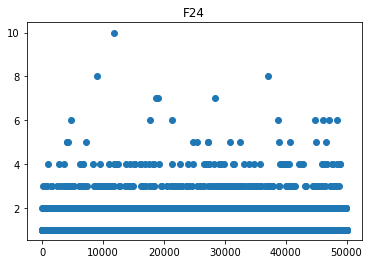

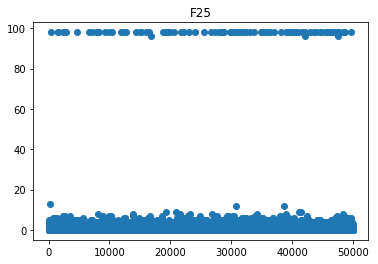

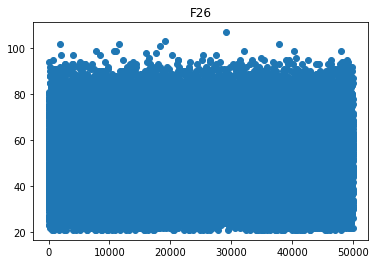

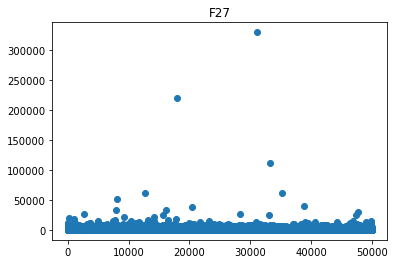

0.93734
0.93956


In [139]:
train = pd.read_csv('/Users/anthonydepalatis/Documents/Workspace/school/MidtermProject379K/data/train.csv')
test = pd.read_csv('/Users/anthonydepalatis/Documents/Workspace/school/MidtermProject379K/data/test.csv')

plot_features(train)

# Train an xgb model with default hyper params and get the initial AUC.
gbm = xgb.XGBClassifier()
cross_validate(train.drop(['id', 'Y'], axis=1), train['Y'], 5, gbm)

# Stack xgb with default hyper params.
train, test = stack_model(gbm, train, test, 'xgb1')
#cross_validate(train.drop(['id', 'Y'], axis=1), train['Y'], 5, xgb.XGBClassifier(n_estimators=78))

# Stack xgb with optimized n_estimators.
#gbm = xgb.XGBClassifier(n_estimators=78)
#train, test = stack_model(gbm, train, test, 'xgb2')

# Initialize final model.
gbm = xgb.XGBClassifier()
cross_validate(train.drop(['id', 'Y'], axis=1), train['Y'], 5, gbm)

# Make final predictions
gbm.fit(train.drop(['id', 'Y'], axis=1), train['Y'])
test_preds = gbm.predict_proba(test.drop(['id'], axis=1))[:,1]
submission = pd.DataFrame({"Id":test.id, "Y":test_preds})
submission.to_csv('/Users/anthonydepalatis/Documents/Workspace/school/MidtermProject379K/submission.csv', index=False)